<a href="https://colab.research.google.com/github/MFH97/Artificial-Intelligence/blob/main/K_Menas_Clustering(datacamp).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to k-Means Clustering with scikit-learn in Python {California Housing Prices}

In this tutorial, learn how to apply k-Means Clustering with scikit-learn in Python

In this tutorial, we will be using California housing data from Kaggle ([here](https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download)). We will use location data (latitude and longitude) as well as the median house value. We will cluster the houses by location and observe how house prices fluctuate across California. We save the dataset as a csv file called ‘housing.csv’ in our working directory and read it using pandas.

# About Dataset
**Context**

This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome.

The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

**Content**

The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. Be warned the data aren't cleaned so there are some preprocessing steps required! The columns are as follows, their names are pretty self explanitory:

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

In [2]:
import pandas as pd

home_data = pd.read_csv('housing.csv', usecols = ['longitude', 'latitude', 'median_house_value'])
home_data.head()

longitude  latitude  median_house_value
0    -122.23     37.88            452600.0
1    -122.22     37.86            358500.0
2    -122.24     37.85            352100.0
3    -122.25     37.85            341300.0
4    -122.25     37.85            342200.0

The data include 3 variables that we have selected using the usecols parameter:

* **longitude**: A value representing how far west a house is. Higher values represent houses that are further West.
* **latitude**: A value representing how far north a house is. Higher values represent houses that are further north.

* **median_house_value**: The median house price within a block measured in USD.

# Visualize the Data

<Axes: xlabel='longitude', ylabel='latitude'>

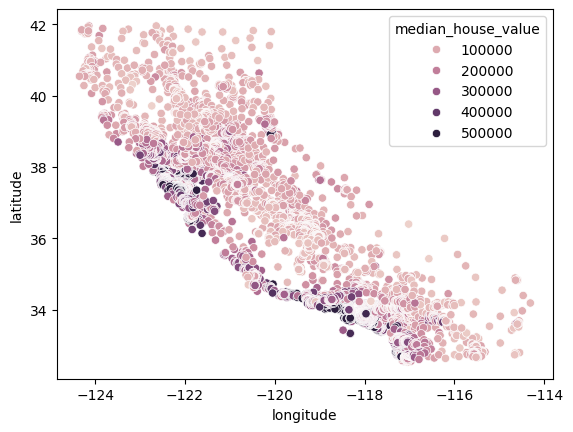

In [3]:
import seaborn as sns

sns.scatterplot(data = home_data, x = 'longitude', y = 'latitude', hue = 'median_house_value')

We see that most of the expensive houses are on the west coast of California with different areas that have clusters of moderately priced houses. This is expected as typically waterfront properties are worth more than houses that are not on the coast.

Clusters are often easy to spot when you are only using 2 or 3 features.

# Normalizing the Data

When working with distance-based algorithms, like k-Means Clustering, we must normalize the data. If we do not normalize the data, variables with different scaling will be weighted differently in the distance formula that is being optimized during training. For example, if we were to include price in the cluster, in addition to latitude and longitude, price would have an outsized impact on the optimizations because its scale is significantly larger and wider than the bounded location variables.

We first set up training and test splits using train_test_split from sklearn.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(home_data[['latitude', 'longitude']], home_data[['median_house_value']], test_size=0.33, random_state=0)

Next, we normalize the training and test data using the preprocessing.normalize() method from sklearn.

In [5]:
from sklearn import preprocessing

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

# Fitting and Evaluating the Model

For the first iteration, we will arbitrarily choose a number of clusters (referred to as k) of 3. Building and fitting models in sklearn is very simple. We will create an instance of KMeans, define the number of clusters using the n_clusters attribute, set n_init, which defines the number of iterations the algorithm will run with different centroid seeds, to “auto,” and we will set the random_state to 0 so we get the same result each time we run the code.  We can then fit the model to the normalized training data using the fit() method.

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

KMeans(n_clusters=3, random_state=0)

Once the data are fit, we can access labels from the labels_ attribute. Below, we visualize the data we just fit.

<Axes: xlabel='longitude', ylabel='latitude'>

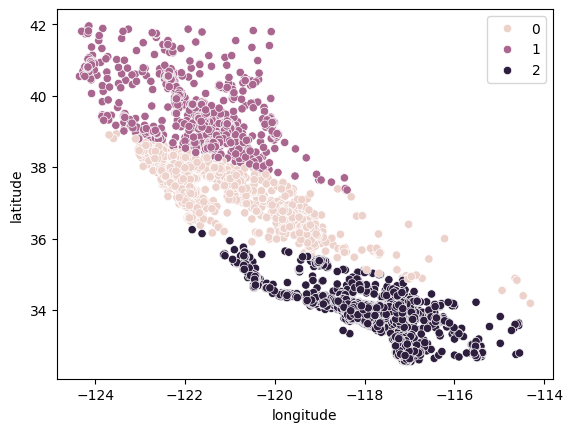

In [8]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

We see that the data are now clearly split into 3 distinct groups (Northern California, Central California, and Southern California). We can also look at the distribution of median house prices in these 3 groups using a boxplot.

<Axes: ylabel='median_house_value'>

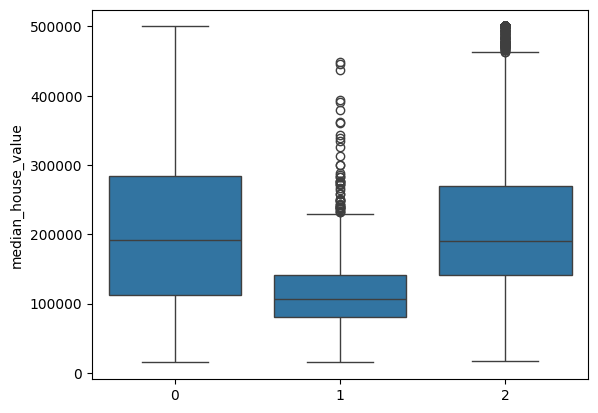

In [9]:
sns.boxplot(x = kmeans.labels_, y = y_train['median_house_value'])

We clearly see that the Northern and Southern clusters have similar distributions of median house values (clusters 0 and 2) that are higher than the prices in the central cluster (cluster 1).

We can evaluate performance of the clustering algorithm using a Silhouette score which is a part of sklearn.metrics where a lower score represents a better fit.

In [10]:
from sklearn.metrics import silhouette_score

silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')

np.float64(0.7499371920703546)

Since we have not looked at the strength of different numbers of clusters, we do not know how good of a fit the k = 3 model is. In the next section, we will explore different clusters and compare performance to make a decision on the best hyperparameter values for our model.

# Choosing the best number of clusters

The weakness of k-means clustering is that we don’t know how many clusters we need by just running the model. We need to test ranges of values and make a decision on the best value of k. We typically make a decision using the Elbow method to determine the optimal number of clusters where we are both not overfitting the data with too many clusters, and also not underfitting with too few.

We create the below loop to test and store different model results so that we can make a decision on the best number of clusters.

In [11]:
K = range(2, 8)
fits = []
score = []


for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X_train_norm)

    # append the model to fits
    fits.append(model)

    # Append the silhouette score to scores
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

We can then first visually look at a few different values of k.

First we look at k = 2.

<Axes: xlabel='longitude', ylabel='latitude'>

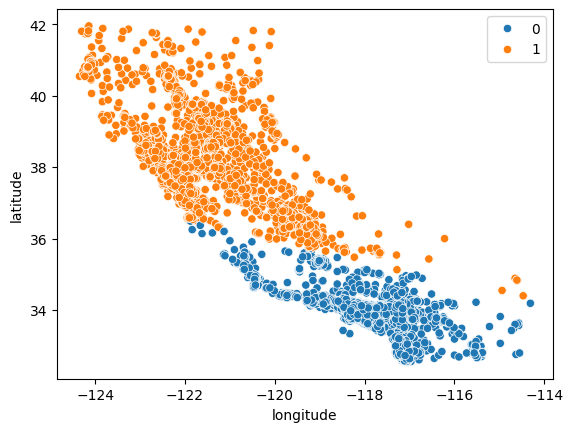

In [12]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[0].labels_)

The model does an ok job of splitting the state into two halves, but probably doesn’t capture enough nuance in the California housing market.

Next, we look at k = 4.

<Axes: xlabel='longitude', ylabel='latitude'>

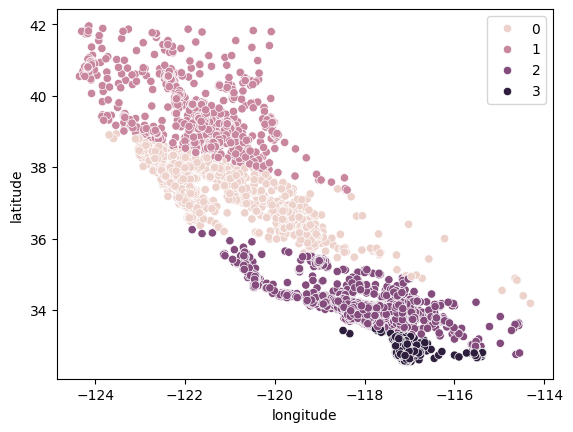

In [13]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

We see this plot groups California into more logical clusters across the state based on how far North or South the houses are in the state. This model most likely captures more nuance in the housing market as we move across the state.

Finally, we look at k = 7.

<Axes: xlabel='longitude', ylabel='latitude'>

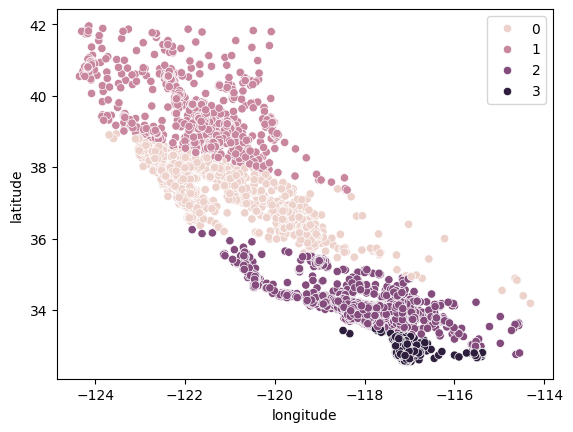

In [14]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

The above graph appears to have too many clusters. We have sacrifice easy interpretation of the clusters for a “more accurate” geo-clustering result.

Typically, as we increase the value of K, we see improvements in clusters and what they represent until a certain point. We then start to see diminishing returns or even worse performance. We can visually see this to help make a decision on the value of k by using an elbow plot where the y-axis is a measure of goodness of fit and the x-axis is the value of k.

<Axes: >

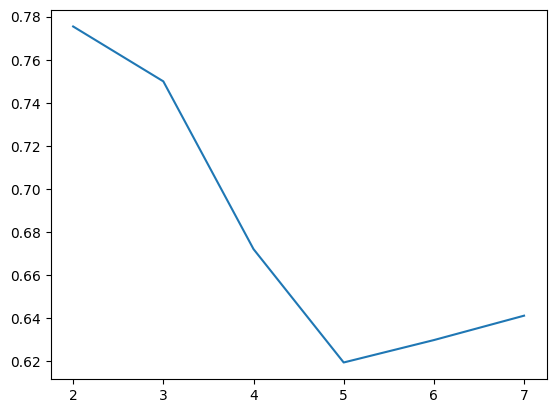

In [15]:
sns.lineplot(x = K, y = score)

We typically choose the point where the improvements in performance start to flatten or get worse. We see k = 5 is probably the best we can do without overfitting.

We can also see that the clusters do a relatively good job of breaking California into distinct clusters and these clusters map relatively well to different price ranges as seen below.

<Axes: xlabel='longitude', ylabel='latitude'>

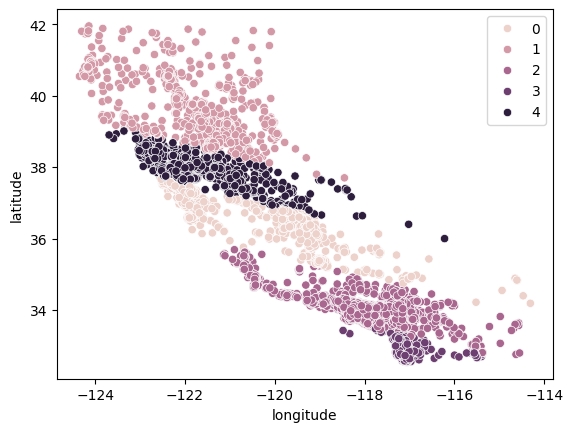

In [16]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[3].labels_)

<Axes: ylabel='median_house_value'>

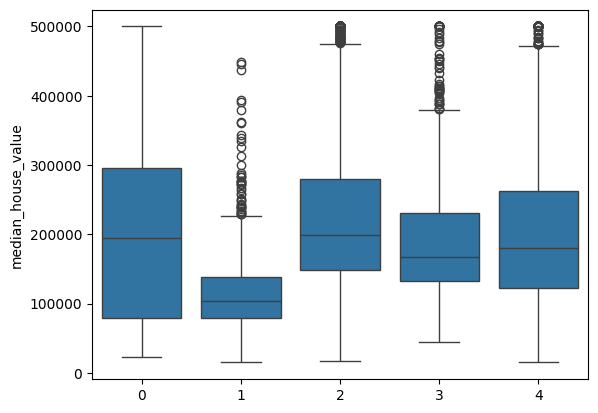

In [17]:
sns.boxplot(x = fits[3].labels_, y = y_train['median_house_value'])

# When will k-means cluster analysis fail?
**K-means clustering performs best on data that are spherical**. Spherical data are data that group in space in close proximity to each other either. This can be visualized in 2 or 3 dimensional space more easily. Data that aren’t spherical or should not be spherical do not work well with k-means clustering. For example, k-means clustering would not do well on the below data as we would not be able to find distinct centroids to cluster the two circles or arcs differently, despite them clearly visually being two distinct circles and arcs that should be labeled as such.

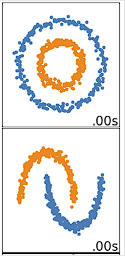

There are many other clustering algorithms that do a good job of clustering non-spherical data, covered in Clustering in Machine Learning: 5 Essential Clustering Algorithms.

Reference: [link](https://www.datacamp.com/tutorial/k-means-clustering-python)